In [8]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats


In [9]:
from pymc import rbeta

class Bandits(object):
  """
  This class represents N bandits.

  parameters:
    p_array: an (N,) NumPy array of probabilities >0, <1.

  methods:
    pull(i): return the results, 0 or 1, of pulling
          the ith bandit.
  """
  def __init__(self, p_array):
    self.p = p_array
    self.optimal = np.argmax(p_array)

  def pull(self, i):
    # i is which arm to pull. Returns True if a reward is earned, False else.
    return np.random.rand() < self.p[i]

  def __len__(self):
    return len(self.p)


class BayesianStrategy(object):
  """
  Implements an online learning strategy to solve
  the multi-armed bandit problem.

  parameters:
    bandits: a Bandit class with .pull method

  methods:
    sample_bandits(n): sample and train on n pulls.
  attributes:
    N: the cumulative number of samples
    choices: the historical choices as an (N,) array
    bb_score: the historical score as an (N,) array
  """

  def __init__(self, bandits):

    self.bandits = bandits
    n_bandits = len(self.bandits)
    self.wins = np.zeros(n_bandits)
    self.trials = np.zeros(n_bandits)
    self.N = 0
    self.choices = []
    self.bb_score = []


  def sample_bandits(self, n=1):

    bb_score = np.zeros(n)
    choices = np.zeros(n)

    for k in range(n):
      # sample from the bandit's priors, and select the largest sample
      choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))
        
#       If interested in the minimum probability 
# (e.g., where prizes are a bad thing), choose B = argmin Xb and proceed.
      
      # sample the chosen bandit
      result = self.bandits.pull(choice)

      # update priors and score
      self.wins[choice] += result
      self.trials[choice] += 1
      bb_score[k] = result
      self.N += 1
      choices[k] = choice

    self.bb_score = np.r_[self.bb_score, bb_score]
    self.choices = np.r_[self.choices, choices]
    return

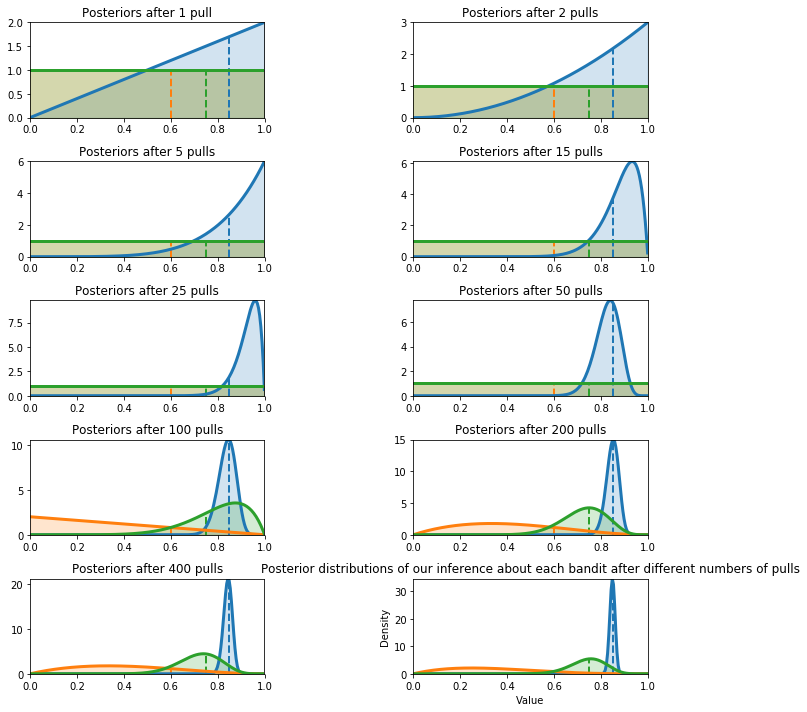

In [13]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
  # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color=c, alpha=alpha,
              label="underlying probability: %.2f"%prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                 colors=c, linestyles="--", lw=2)
            plt.autoscale(tight="True")
            plt.title("Posteriors after %d pull"%bayesian_strategy.N +\
                "s"*(bayesian_strategy.N>1))
            plt.autoscale(tight=True)
    return

hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
  plt.subplot(5, 2, j+1)
  bayesian_strat.sample_bandits(i)
  plot_priors(bayesian_strat, hidden_prob)
  plt.autoscale(tight=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of our inference about each bandit after different numbers of pulls")
plt.tight_layout()

From the text:

Suppose you are faced with ten slot machines (colorfully called multi-armed bandits). Each bandit has an unknown probability of distributing a prize (assume for now that the prizes are the same for each bandit; only the probabilities differ). Some bandits are very generous, others not so much. Of course, you don’t know what these probabilities are. By only choosing one bandit per round, our task is devise a strategy to maximize our winnings.

Of course, if we knew the bandit with the largest probability, then always picking this bandit would yield the maximum winnings. So our task can be phrased as “Find the best bandit as quickly as possible.”

The task is complicated by the stochastic nature of the bandits. A suboptimal bandit can return many winnings, purely by chance, which would make us believe that it is a very profitable bandit. Similarly, the best bandit can return many duds, by chance. Should we keep trying losers, then, or give up?

A more troublesome problem is, if we have found a bandit that returns pretty good results, do we keep drawing from it to maintain our pretty good score, or do we try other bandits in hopes of finding an even better bandit? This is the exploration versus exploitation dilemma.




The algorithm starts in an ignorant state, where it knows nothing, and begins to acquire data by testing the system. As it acquires data and results, it learns what the best and worst behaviors are (in this case, it learns which bandit is the best). With this in mind, perhaps we can add an additional application of the multi-armed bandit problem:

The Bayesian solution begins by assuming priors on the probability of winning for each bandit. In our vignette, we assumed complete ignorance of these probabilities. So a very natural prior is the flat prior over 0 to 1. The algorithm proceeds as follows:

1. Sample a random sample Xb from the prior of bandit b, for all b.

2. Select the bandit with highest sample; that is, select B = argmax Xb.

3. Observe the result of pulling bandit B, and update your prior on bandit B.

4. Return to 1.

That’s it. Computationally, the algorithm involves sampling from N distributions. Since the initial priors are Beta(α= 1, β = 1), a uniform distribution, and the observed result X (a win or loss, encoded 1 and 0, respectively) is binomial, the posterior is a Beta(α = 1 + X, β = 1 + 1 − X).

To answer our question from before, this algorithm suggests that we should not discard losers, but rather should pick them at a decreasing rate as we gather confidence that there exist better bandits. This follows because there is always a non-zero chance that a loser will become B, the bandit with the largest sample, but the probability of this event decreases as we play more rounds 

Adding learning rates: Suppose the underlying environment may change over time. Technically, the standard Bayesian Bandits algorithm would self-update (awesome!) by noting that what it thought was the best is starting to fail more often. We can motivate the algorithm to learn changing environments more quickly by simply adding a rate term upon updating.



In [15]:
# self.wins[ choice ] = rate*self.wins[ choice ] + result
# self.trials[ choice ] = rate*self.trials[ choice ] + 1

If rate < 1, the algorithm will forget its previous wins more quickly and there will be a downward pressure toward ignorance. Conversely, setting rate > 1 implies your algorithm will act in a riskier manner, and bet on earlier winners more often and be more resistant to changing environments.

Hierarchical algorithms: We can set up a Bayesian Bandits algorithm on top of smaller bandit algorithms. Suppose we have N Bayesian Bandits models, each varying in some behavior (for example, different rate parameters, representing varying sensitivity to changing environments). On top of these N models is another Bayesian Bandits learner that will select a sub-Bayesian Bandits. This chosen Bayesian Bandits will then make an internal choice as to which machine to pull. The super-Bayesian Bandits updates itself depending on whether the sub-Bayesian Bandits was correct or not.

Extending the rewards, denoted ya for bandit A, to random variables from a distribution fya(y) is straightforward. More generally, this problem can be rephrased as “Find the bandit with the largest expected value,” as playing the bandit with the largest expected value is optimal. In the preceding case, fya was a Bernoulli random variable with probability pa, hence the expected value for a bandit is equal to pa, which is why it looks like we are aiming to maximize the probability of winning. If the prize is not Bernoulli, and it is non-negative, which can be accomplished by shifting the distribution (we assume we know f), then the algorithm behaves as before:

For each round,

1. Sample a random variable Xb from the prior of bandit b, for all b.

2. Select the bandit with largest sample; that is, select bandit B = argmax Xb.

3. Observe the result, R ~ fyb, of pulling bandit B, and update your prior on bandit B.

4. Return to 1.

The issue is in the sampling of the Xb drawing phase. With Beta priors and Bernoulli observations, we have a Beta posterior; this is easy to sample from. But now, with arbitrary distributions f, we have a non-trivial posterior. Sampling from these can be difficult.

